In [1]:
#declare libraries
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
import datetime
from dateutil.relativedelta import relativedelta #DOWNLOAD THIS PACKAGE#
import os
import requests #DOWNLOAD THIS PACKAGE#
import zipfile #DOWNLOAD THIS PACKAGE#
import io #DOWNLOAD THIS PACKAGE#
import pandas as pd
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import subprocess as sp
import os
import time
import pylab as pl
import scipy.stats
from shapely.geometry import Point
import statsmodels.formula.api as smf
import geopandas as gpd
import random
import json
from fiona.crs import from_epsg
import pysal as ps
import math
import matplotlib.pylab as plt
import matplotlib as mpl
import seaborn as sbn
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
import statsmodels.api as sm

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
    puidata = os.getenv("PUIDATA")

In [3]:
#i got these links from http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml
# essentially these are just the trip level data for hire vehicles, green and yellow taxi datasets for June 2018
#download data and place them into the PUIdata folder
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/fhv_tripdata_2018-06.csv > ~/PUIdata/fhv_tripdata_2018-06.csv
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2018-06.csv > ~/PUIdata/green_tripdata_2018-06.csv
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-06.csv > ~/PUIdata/yellow_tripdata_2018-06.csv

#lookup table related to taxi zones
!curl https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv > ~/PUIdata/taxi+_zone_lookup.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1366M  100 1366M    0     0  41.8M      0  0:00:32  0:00:32 --:--:-- 60.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63.1M  100 63.1M    0     0  46.1M      0  0:00:01  0:00:01 --:--:-- 46.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  733M  100  733M    0     0  50.8M      0  0:00:14  0:00:14 --:--:-- 57.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12322  100 12322    0     0  69338      0 --:--:-- --:--:-- --:--:-- 69224


In [4]:
#fix to remove empty line at line 2 of yellow_trip_data
#!sed -i '2d' ~/PUIdata/yellow_tripdata_2018-06.csv

In [5]:
#download shapefiles related to taxizones 
def dl_unzip(url,output_path):
    '''
    description: downloads a zipfile, given a url address and unpacks it at provided location
    ----------------------------------------------------------------------------------
    Parameters - Parameter Type - Description - Example input
    1.) url - <string> - refers url address for the zipfile - "http://www.lalaland.com/goose.zip"
    2.) output_path - <string> - refers to the working directory where you want to unpack your file - "~\sebs_bar"
    ----------------------------------------------------------------------------------
    room for improvement
    1.) error handling
    2.) returns status
    
    has dependencies on the following packages
    requests
    zipfile
    ----------------------------------------------------------------------------------
    Example usage:
    dl_unzip("http://www.lalaland.com/goose.zip","~/sebs_bar")
    '''    
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(output_path)
    
dl_unzip("https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip",puidata)

In [6]:
yellow = pd.read_csv('~/PUIdata/yellow_tripdata_2018-06.csv')
green = pd.read_csv('~/PUIdata/green_tripdata_2018-06.csv')
FHV = pd.read_csv('~/PUIdata/fhv_tripdata_2018-06.csv')

In [7]:
lookup_id = pd.read_csv('~/PUIdata/taxi+_zone_lookup.csv')

In [8]:
lookup_id.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [9]:
borough = dict(zip(lookup_id['LocationID'],lookup_id['Borough']))
zone = dict(zip(lookup_id['LocationID'],lookup_id['Zone']))

In [10]:
yellow.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-06-01 00:15:40,2018-06-01 00:16:46,1,0.0,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30
1,1,2018-06-01 00:04:18,2018-06-01 00:09:18,1,1.0,1,N,230,161,1,5.5,0.5,0.5,1.35,0.0,0.3,8.15
2,1,2018-06-01 00:14:39,2018-06-01 00:29:46,1,3.3,1,N,100,263,2,13.0,0.5,0.5,0.00,0.0,0.3,14.30
3,1,2018-06-01 00:51:25,2018-06-01 00:51:29,3,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80
4,1,2018-06-01 00:55:06,2018-06-01 00:55:10,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80


In [11]:
green.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2018-06-01 00:33:55,2018-06-01 00:36:13,N,1,66,33,5,0.51,4.0,0.5,0.5,0.70,0.0,NaN,0.3,6.00,1,1
1,2,2018-06-01 00:40:36,2018-06-01 00:49:46,N,1,25,49,5,1.97,9.0,0.5,0.5,2.06,0.0,NaN,0.3,12.36,1,1
2,2,2018-06-01 00:57:12,2018-06-01 01:02:58,N,1,61,49,5,1.40,6.5,0.5,0.5,0.00,0.0,NaN,0.3,7.80,2,1
3,2,2018-06-01 00:10:13,2018-06-01 00:16:27,N,1,49,97,1,1.36,7.0,0.5,0.5,0.00,0.0,NaN,0.3,8.30,2,1
4,1,2018-06-01 00:32:08,2018-06-01 00:52:06,N,1,75,127,1,7.90,24.0,0.5,0.5,6.30,0.0,NaN,0.3,31.60,1,1


In [12]:
FHV.head()

,Dispatching_base_num,Pickup_DateTime,DropOff_datetime,PUlocationID,DOlocationID,SR_Flag
0,B00628,2018-06-11 00:10:20,2018-06-11 01:13:39,88.0,200.0,NaN
1,B00628,2018-06-11 05:12:50,2018-06-11 06:53:50,95.0,132.0,NaN
2,B00628,2018-06-11 05:14:16,2018-06-11 06:21:59,142.0,132.0,NaN
3,B00628,2018-06-11 05:15:23,2018-06-11 06:27:47,236.0,132.0,NaN
4,B00628,2018-06-11 06:36:46,2018-06-11 07:34:50,158.0,1.0,NaN


## get only the necessary columns from each dataset. For this assignment i only need the pickup-dropoff pairs for each vehicle type. 

In [13]:
drop_cols=[x for x in yellow.columns.get_values() if x not in ['PULocationID','DOLocationID']]
yellow=yellow.drop(drop_cols,axis=1)

In [14]:
drop_cols=[x for x in green.columns.get_values() if x not in ['PULocationID','DOLocationID']]
green=green.drop(drop_cols,axis=1)

In [15]:
drop_cols=[x for x in FHV.columns.get_values() if x not in ['PUlocationID','DOlocationID']]
FHV=FHV.drop(drop_cols,axis=1)

In [16]:
yellow.head()

,PULocationID,DOLocationID
0,145,145
1,230,161
2,100,263
3,145,145
4,145,145


In [17]:
green.head()

,PULocationID,DOLocationID
0,66,33
1,25,49
2,61,49
3,49,97
4,75,127


In [18]:
FHV.head()

,PUlocationID,DOlocationID
0,88.0,200.0
1,95.0,132.0
2,142.0,132.0
3,236.0,132.0
4,158.0,1.0


In [19]:
#dropnas
yellow.dropna(inplace=True)
green.dropna(inplace=True)
FHV.dropna(inplace=True)

In [20]:
#fix FHV's PUlocationID, DOlocationID
FHV['PUlocationID'] = FHV['PUlocationID'].astype(int) 
FHV['DOlocationID'] = FHV['DOlocationID'].astype(int)
FHV.rename(columns={"PUlocationID":"PULocationID","DOlocationID":"DOLocationID"},inplace=True)

In [21]:
FHV.head()

,PULocationID,DOLocationID
0,88,200
1,95,132
2,142,132
3,236,132
4,158,1


In [22]:
datalist = [yellow,green,FHV]
columnlist = ['PULocationID','DOLocationID']
dictlist = ["borough","zone"]
init = 0
for i in datalist:
    for j in columnlist:
            for x in dictlist:
                i[j+"_"+x] = i[j].map(eval(x))

In [23]:
yellow.head()

,PULocationID,DOLocationID,PULocationID_borough,PULocationID_zone,DOLocationID_borough,DOLocationID_zone
0,145,145,Queens,Long Island City/Hunters Point,Queens,Long Island City/Hunters Point
1,230,161,Manhattan,Times Sq/Theatre District,Manhattan,Midtown Center
2,100,263,Manhattan,Garment District,Manhattan,Yorkville West
3,145,145,Queens,Long Island City/Hunters Point,Queens,Long Island City/Hunters Point
4,145,145,Queens,Long Island City/Hunters Point,Queens,Long Island City/Hunters Point


In [24]:
allthetables = pd.concat([yellow,green,FHV])

In [25]:
pickups = allthetables[['PULocationID','PULocationID_borough','PULocationID_zone']]
dropoffs = allthetables[['DOLocationID','DOLocationID_borough','DOLocationID_zone']]
pickups.rename(columns={"PULocationID":"LocationID"},inplace=True)
dropoffs.rename(columns={"DOLocationID":"LocationID"},inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [26]:
pickups_cnt = pickups.groupby('LocationID').count().reset_index()
dropoffs_cnt = dropoffs.groupby('LocationID').count().reset_index()

In [27]:
pickups_cnt.head()

,LocationID,PULocationID_borough,PULocationID_zone
0,0,0,0
1,1,3586,3586
2,2,58,58
3,3,30832,30832
4,4,98161,98161


In [28]:
dropoffs_cnt.head()

,LocationID,DOLocationID_borough,DOLocationID_zone
0,0,0,0
1,1,127393,127393
2,2,56,56
3,3,30072,30072
4,4,105146,105146


### load the shapefile

In [29]:
taxishp = gpd.GeoDataFrame.from_file(puidata+"/"+"taxi_zones.shp")

In [30]:
taxishp.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ..."


In [31]:
PU_Taxishp = pd.merge(taxishp,pickups_cnt[['PULocationID_zone','LocationID']])

In [32]:
DO_Taxishp = pd.merge(taxishp,dropoffs_cnt[['DOLocationID_zone','LocationID']])

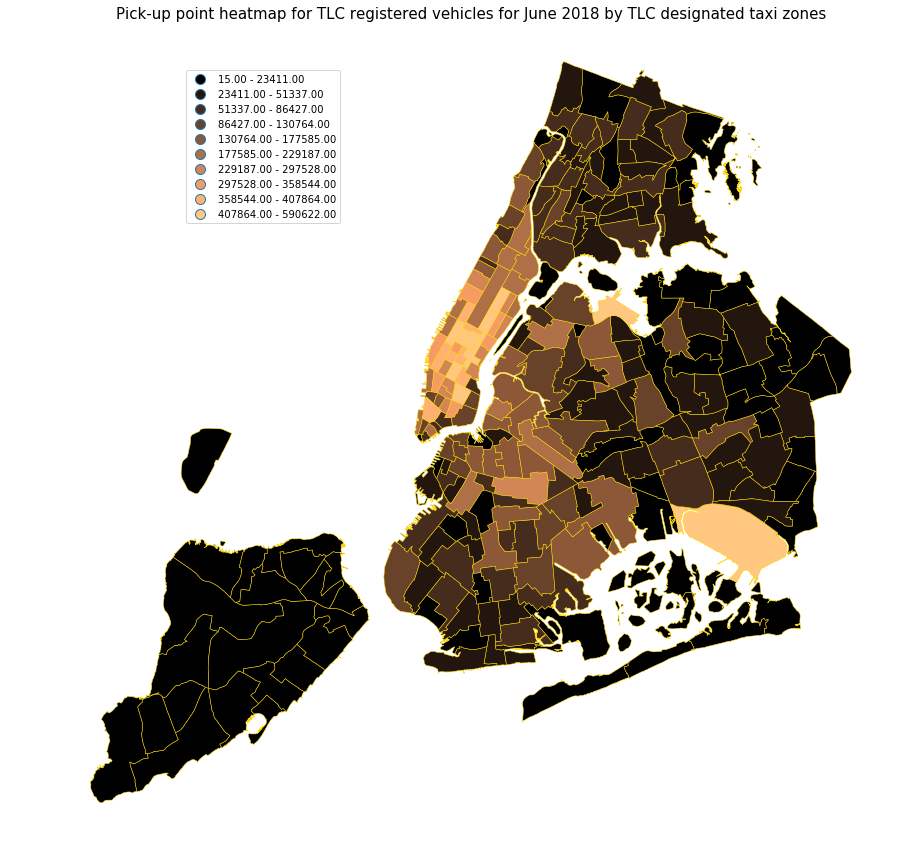

In [41]:
fig = pl.figure(figsize = (15,15))
ax = fig.add_subplot(111)
#taxishp.plot(ax=ax)
PU_Taxishp.plot(ax=ax, column='PULocationID_zone',cmap='copper',alpha=1,scheme='fisher_jenks', k=10,  edgecolor='gold', lw=0.5, legend=True)
ax.set_title('Pick-up point heatmap for TLC registered vehicles for June 2018 by TLC designated taxi zones', fontsize=15)
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
plt.savefig("pickup_june2018.png")

### Figure 1 : This shows the magnitude of the frequency of TLC registered vehicles (Yellow, Green and For hire vehicles) pickups in NYC during June 2018. Manhattan and Brooklyn seem to show more pickups compared to other except. It's quite notable that a particular area in Queens has a high frequenct of pickups, this is just Jamaica area which contains JFK airport.

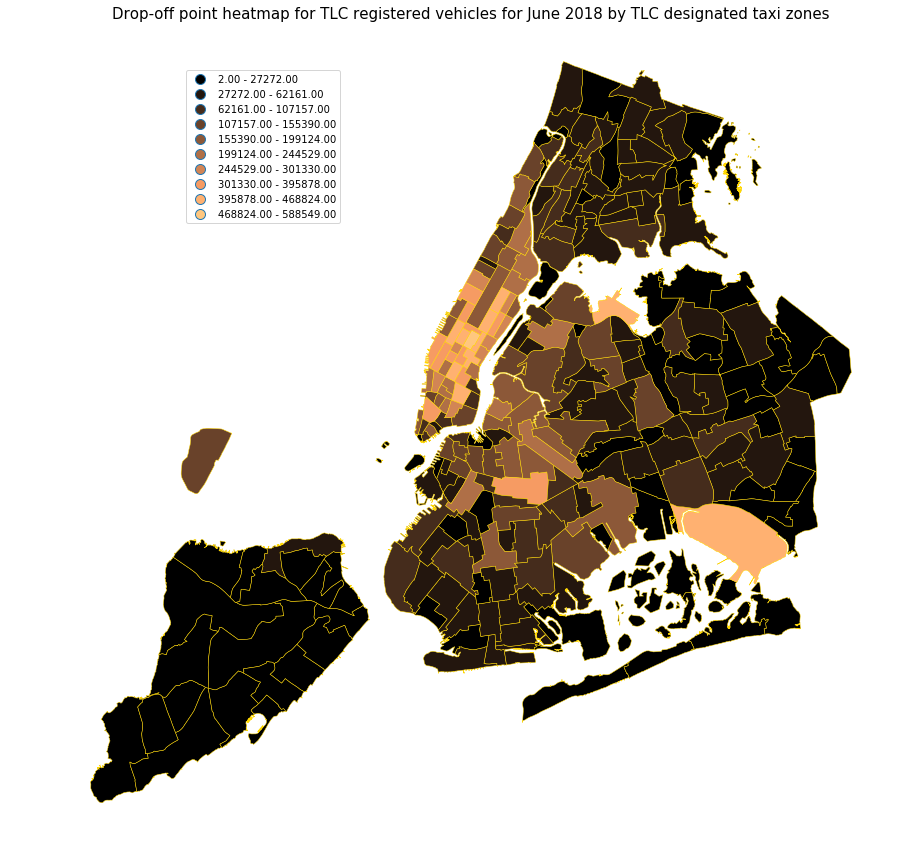

In [40]:
fig = pl.figure(figsize = (15,15))
ax = fig.add_subplot(111)
#taxishp.plot(ax=ax)
DO_Taxishp.plot(ax=ax, column='DOLocationID_zone',cmap='copper',alpha=1,scheme='fisher_jenks', k=10,  edgecolor='gold', lw=0.5, legend=True)
ax.set_title('Drop-off point heatmap for TLC registered vehicles for June 2018 by TLC designated taxi zones', fontsize=15)
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))
plt.savefig("dropoff_june2018.png")

### Figure 2 : This shows the magnitude of the frequency of TLC registered vehicles (Yellow, Green and For hire vehicles) drop-offs in NYC during June 2018. From the scale of the map, it seems like the same areas in figure 2 are lit similar to figure 1's. Maybe a more borough level investigation might reveal something interesting...